Objective
=====

The objective is to look at a simplified scenario of solar + storage and assess the relative merits of different levels of storage contribution to the solar plant.  An indicative year’s worth of hypothetical solar generation time series and associated wholesale energy market prices are provided in CSV format.  Assume that these are representative of the whole project life (term).  A list of assumptions are provided below to assist with the calculations.

Based on the provided data and assumptions please:
1.	Calculate Levelised Cost of Energy (LCOE) and Internal Rate of Return (IRR) for the solar project alone;
2.	Calculate the volume weighted average market revenue for the solar project, and compare this against the LCOE;
3.	Devise a model that utilises energy storage to shift solar energy to higher price periods

        a.	Note that degrees of freedom include storage sizes on a MW and MWh basis
        
4.	Calculate new volume weighted average market revenues and compare to  changed LCOE (due to storage addition) and new market revenue IRR’s and comment.



Assumptions
-----------
### Capital Costs (CAPEX):

* Solar: 
    - \$1.28/W installed 
    - \$5M connection costs (includes transformers, switch gear, etc.);
* Storage:
    - \$300,000 / MWh for batteries installed;
    - \$15,000 / MW for inverters installed;
    - \$200,000 / container which houses 2MWh of batteries;
    - \$5M connection costs  (includes transformers, switch gear, etc.);
    
### Operational Costs (OPEX)

* Solar:
    - Annual OPEX at 2% of CAPEX
* Storage:
    - Annual OPEX at 2% of CAPEX
    
### Escalation rates

* CPI:
	- 2.5%
*	Discount rate (weighted average cost of capital)
	- 9%
    
### Efficiencies

*	Storage round trip efficiency (Charge – Discharge):
	- 88%
*	Parasitic loads:
	- Assume none
*	Storage degradation:
	- Assume 1% of capacity per year.
    
### Project Life

*	Assume 20 year project life
*   No terminal value





In [1]:
import numpy as np
import pandas as pd
%pylab inline
pylab.rcParams['figure.figsize'] = 8, 4

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Import data from .csv file
data = pd.read_csv('Example_solar_generation_energy_price.csv', index_col=0, parse_dates=True, dayfirst=True, usecols=[0,1,2], nrows=8760)

energy_price = data['Energy Price ($/MWh)'].values
solar_generation = data['Solar Generation (MW)'].values

### 1.	Calculate Levelised Cost of Energy (LCOE) and Internal Rate of Return (IRR) for the solar project alone


The LCOE measures lifetime costs of the plant divided by energy production over that lifetime, and is a useful parameter to compare different methods of electricity generation. Since the result is an economic assessment of the power plant, many different factors can influence the result and therefore it is important to evaluate every component of the formula.
In order to calculate the LCOE for the solar project, the following assumptions have been made:

* Since the maximum production during the first year is about 98 MW (data observed from the imported .csv file), we assume the plant size to be 100 MW; 
* The initial cost, given by the sum of the plant and connection costs, is considered only for the first year;
* No incentives are available for this plant size (according to the italian regulation of 2017);
* No disposal costs are evaluated;
* The degradation factor for the PV modules is assumed to be 0.5 %;
* A taxation of 20% is considered.


In [3]:
# data
unit_cost       = 1.28*10**6 # $/MW
connection_cost = 5000000 # $
size            = 100 # MW
cpi             = 0.025
r               = 0.09 # discount rate
degradation_pv  = 0.005
year            = np.arange(1, 21)
tax             = 0.20

# LCOE calculation
init_cost       = size*unit_cost + connection_cost
oper_cost       = 0.02*init_cost
first_year_prod = np.sum(solar_generation) # .csv data
actual_prod     = np.sum((first_year_prod*(1-degradation_pv)**year)/(1+r)**year)
actual_oper_cost = np.sum((oper_cost*(1+cpi)**year)/(1+r)**year)

LCOE = ((init_cost+actual_oper_cost)/actual_prod)/1000 # $/kWh
print('LCOE is %f $'%LCOE)

LCOE is 0.079195 $


For the calculation of the Net Present Value, 10 years of amortisation are considered. This will have an influence on the cash flows and consequently on the NPV. Once calculated the NPV, the Internal Rate of Return of the solar project can be evaluated. This can be seen as the rate of growth a project is expected to generate [[1]](http://www.investopedia.com/terms/i/irr.asp).

In [4]:
# NPV calculation

amortisation    = init_cost/10 # 10 years amortisation are considered
profit          = np.sum(energy_price*solar_generation)
CF10            = np.sum((profit - oper_cost + amortisation)*(1-tax)/(1+r)**year[0:10]) # 1-10 years
CF20            = np.sum((profit - oper_cost) * (1-tax)/(1+r)**year[10:20]) # 11 - 20 years
cash_flow       = CF10 + CF20
NPV             = cash_flow - init_cost

print('NPV is %f $' %NPV)

NPV is 97400714.608615 $


In [5]:
def npv_func(r): 
    # referenced variables are defined in the NPV calculation 
    CF10            = np.sum((profit - oper_cost + amortisation)*(1-tax)/(1+r)**year[0:10]) # 1-10 years
    CF20            = np.sum((profit - oper_cost) * (1-tax)/(1+r)**year[10:20]) # 11 - 20 years
    cash_flow       = CF10 + CF20
    NPV             = cash_flow - init_cost
    return NPV

import scipy.optimize
# Return the roots of the (non-linear) equations defined by func(x) = 0 given a starting estimate.
IRR = scipy.optimize.fsolve(npv_func, r)

print('IRR is %f%%'%(IRR*100))

IRR is 19.653974%


The IRR is calculated by means of a function that returns the root of the NPV. The resulting value is the IRR, which equals 19.7%. This means that the solar energy investment is projected to generate a 19.7% return through the life of the solar system.

In this case, the IRR suggests that the project looks attractive, but one has to take into account the previous consideration and the additional costs that have not been considered in this case (e.g. a disposal cost at the end of the lifetime).


### 2.	Calculate the volume weighted average market revenue for the solar project, and compare this against the LCOE

As the LCOE indicates the cost of energy produced by the power plant, a comparison with the volume weighted average market revenue would give an idea of the plant profit. In this case, it results to be 2.7 cent/kWh.

In [6]:
average_revenue = (profit/first_year_prod)/1000 # $/kWh

print('The volume weighted average market revenue is %.3f $/kWh'% average_revenue)

plant_profit = average_revenue - LCOE; # $/kWh

print('The difference between the volume weighted average market revenue and the LCOE is %.3f $/kWh' %plant_profit)

The volume weighted average market revenue is 0.106 $/kWh
The difference between the volume weighted average market revenue and the LCOE is 0.027 $/kWh


### 3. & 4.	Devise a model that utilises energy storage to shift solar energy to higher price periods, calculate new volume weighted average market revenues, compare to  changed LCOE (due to storage addition) and new market revenue IRR’s and comment.


In order to write down a rule for the storage system, the starting point is to impose the energy balance, between the PV unit, the storage system, and the network. Using a single bus bar model, the elements are described as they were all connected to a single bar:

*Ppv(t) + Pnet(t) + Pst(t) = 0*

* Ppv(t) is the power provided by the PV unit in [MW]; 
* Pst(t) in [MW] represents the power exchanged with the storage system, and is negative if it's absorbed;
* Pnet (t) in [kW] is the variable that represents the power exchanged with the external grid.

The goal would be to exploit the storage system to maximise energy sale to the network:

*Pnet (t) ≤ 0* , ∀t.

There are many possibilities to define the model. The idea is to define a model to evaluate the profit that depends on both storage size and energy prices. This model sells the energy of the storage only when the energy price is above a certain threshold (discharge phase), otherwise it would take the energy from the PV production (charge phase). 

Let us see how the charge and discharge phases are defined.


A)	In case of energy price below the threshold, the storage system can be charged absorbing the energy produced according to its limits.

The bounds of the storage system have to be verified in terms of maximum power allowed during charging phase (a charge/discharge power factor of 0.3 is assumed), and in terms of maximum stored energy.
So Pst(t) is given by the most restrictive criterion.

Moreover, implementing a cycle within the numerical code, at each time step the storage system is updated with the new state of charge.
If the storage reaches its limits, a residual energy in excess would be sold to the network, in order to accomplish the energy balance.

Therefore, the system is described by the following set of equations :

In [7]:
def charge_phase(sg,wmax,Wst0,etain):
    pst     =   max([-sg,-0.3*wmax, (Wst0-wmax)/(etain)])
    wst     =   -etain * pst + Wst0
    pnet    =   -sg - pst
    return pst, pnet, wst

B)	In case of energy price above the threshold, the energy (both of the storage and PV) is sold to the network. The bounds of the storage system during discharging phase have to be verified and therefore Pst(t) is given by the following set of equations:

In [8]:
def discharge_phase(sg,wmax,wmin,Wst0,etaout):
    pst     =   min([0.3*wmax, etaout*(Wst0-wmin)])
    wst     =   -pst/etaout+Wst0
    pnet    =   -sg - pst
    return pst, pnet, wst

The model is defined in order to see how the volume weighted average market revenue and the LCOE change by varying both storage size and energy price threshold. 
Therefore, in the following steps a function to calculate the revenue and another one to evaluate the LCOE are defined and subsequently used in the model.

In [9]:
#define functions to calculate volume weighted average market revenue for the PV + STORAGE project

def get_revenue(Pnet, energy_price):
    '''Calculate volume weighted average market revenue for the PV + STORAGE project'''
    profit_pv_sto = np.sum(Pnet * energy_price)
    first_year_network = np.sum(Pnet)
    average_revenue_sto = (profit_pv_sto/first_year_network)/1000 # $/kWh
    return average_revenue_sto

In [10]:
# Storage data

Storage_price_unit = 300000 # $/MWh
Inverter_price = 15000 # $/MW
Container_price = 200000 # for 2 MWh batteries
Connection_price = 5000000
Power_factor = 0.3
degradation_sto = 0.01


In [13]:
def model(solar_generation, energy_price, wmax, ep_threshold):
    '''
        This model sells the energy of the storage only when the energy price is above a certain threshold (discharge phase), 
        otherwise it would take the energy from the PV production (charge phase)
    '''
    wmin      =   0.1 * wmax
    Wst0      =   wmin # initial storage charge (hp: initially charged at 10%)
    Wst = np.zeros_like(solar_generation)
    Pnet = np.zeros_like(solar_generation)
    Pst = np.zeros_like(solar_generation)

    avg_price = np.mean(energy_price)

    for it, sg  in enumerate(solar_generation):
        eg = energy_price[it]
        if eg  <   ep_threshold:
            pst, pnet, wst = charge_phase(sg,wmax,Wst0,etain)
        else:
            pst, pnet, wst = discharge_phase(sg,wmax,wmin,Wst0,etaout)

        Wst[it]  =   wst
        Pnet[it]  =   pnet
        Pst[it]   =   pst
        Wst0      =   wst
    
    return Wst, Pnet, Pst

Text(0,0.5,u'Profit ($/kWh)')

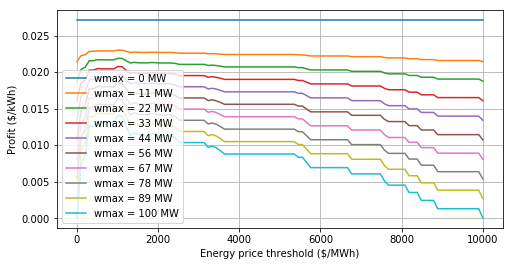

In [14]:
# Storage model depending on storage capacity (wmax) and energy price (ep_threshold)

etain     =   0.88 # Storage efficiency - Charge
etaout    =   0.88 # Storage efficiency - Discharge

# energy price thresholds used for the evaluation of the plant performance
ep_threshold_vector = np.linspace(0, 10000, 100)
wmax_vector = np.linspace(0, 100, 10)
for wmax in wmax_vector:
    avg_rev = []
    lcoe_vector = []
    net_profit_vector = []
    for ep_threshold in ep_threshold_vector:
        
        Wst, Pnet, Pst = model(solar_generation, energy_price, wmax, ep_threshold)
        
        average_revenue_sto = get_revenue(Pnet, energy_price)

        # LCOE calculation (PV+Storage)
        if wmax>0:
            Storage_price = Storage_price_unit * wmax + wmax * Power_factor * Inverter_price + Container_price * wmax * 0.5 + Connection_price
        else:
            Storage_price = 0
        Oper_cost_sto = 0.02 * Storage_price
        first_year_sto = -np.sum(Pst)

        actual_prod     = np.sum((first_year_prod*(1-degradation_pv)**year)/(1+r)**year)
        actual_prod_sto = np.sum((first_year_sto*(1-degradation_sto)**year)/(1+r)**year)
        actual_oper_cost_sto = np.sum(((oper_cost + Oper_cost_sto) * (1 + cpi)**year)/(1 + r)**year)

        LCOE_storage = ((init_cost + Storage_price + actual_oper_cost_sto) / (actual_prod + actual_prod_sto)) / 1000 # $/kWh

        #print('The volume weighted average market revenue is %f $/kWh'% average_revenue_sto)
        net_profit = average_revenue_sto-LCOE_storage
        net_profit_vector.append(net_profit)
        avg_rev.append(average_revenue_sto)
        lcoe_vector.append(LCOE_storage)


    plot(ep_threshold_vector, net_profit_vector, label='wmax = %.0f MW'%wmax)
    
grid()
legend()
xlabel('Energy price threshold ($/MWh)')
ylabel('Profit ($/kWh)')

In the previous figure it is possible to see how the profit changes depending on the energy price threshold (x axis) and the storage size, represented in different colors. 

This model shows that the revenue increases with the storage size, as well as the LCOE, which increases faster due to the addition of storage costs. As a result, this model suggests that it is not convenient to utilise an energy storage for this plant. 

### Example output of the model

The following figure shows an example of the model created for the storage. A storage capacity of 100 MW is selected, as well as an energy price threshold of 100 $/MWh. 

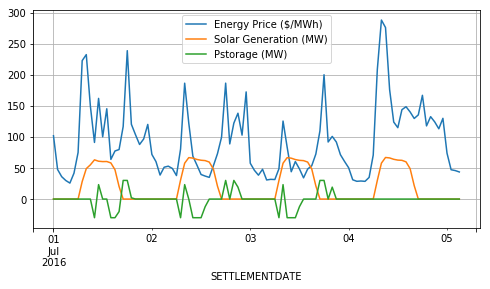

In [16]:
wmax = 100
ep_threshold = 100
Wst, Pnet, Pst = model(solar_generation, energy_price, wmax, ep_threshold)
model_data = data.copy()
model_data['Pstorage (MW)'] = Pst

model_data.iloc[0:100].plot()
grid()

The green trend represents the power charged by the storage (negative values) and the positive values correspond to the energy sale. It is possible to see that the storage is mainly selling energy when the solar generation falls down (orange trend). This implies that the model is selling during the hours of maximum demand and higher prices. 